In [1]:
import os
import pandas as pd
import numpy as np

import re # regular expressions 

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool

output_notebook()

# data source - US Federal Emergency Management Agency
# https://www.fema.gov/media-library/assets/documents/28318

Loading BokehJS ...

In [2]:
# get data to analyze
# if running locally or using data clone from the Git repo, 
# uncomment line 4 below; and comment out line 19 (which gets data from S3)
# data_location = "data.gov.FEMADeclarations.12.3.18.csv"


# set up link to S3 bucket where out data is
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()

# replace the text inside single quotes with your S3 bucket name
bucket='sagemaker-setup-demo-pragamaticai-00'

# replace the text inside single quotes with your file name in S3 that has your data
data_key = 'data.gov.FEMADeclarations.12.3.18.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

# read data file
df = pd.read_csv(data_location, sep=',')

df.head(3)

,Disaster Number,IH Program Declared,IA Program Declared,PA Program Declared,HM Program Declared,State,Declaration Date,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,Place Code,Declared County/Area,Declaration Request Number
0,3410.0,No,No,Yes,No,AK,11/30/2018,EM,Earthquake,EARTHQUAKE,11/30/2018,11/30/2018,NaN,99020.0,Anchorage (Borough),18133.0
1,3410.0,No,No,Yes,No,AK,11/30/2018,EM,Earthquake,EARTHQUAKE,11/30/2018,11/30/2018,NaN,99122.0,Kenai Peninsula (Borough),18133.0
2,3410.0,No,No,Yes,No,AK,11/30/2018,EM,Earthquake,EARTHQUAKE,11/30/2018,11/30/2018,NaN,99170.0,Matanuska-Susitna (Borough),18133.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48428 entries, 0 to 48427
Data columns (total 16 columns):
Disaster Number               48427 non-null float64
IH Program Declared           48427 non-null object
IA Program Declared           48427 non-null object
PA Program Declared           48427 non-null object
HM Program Declared           48427 non-null object
State                         48427 non-null object
Declaration Date              48427 non-null object
Disaster Type                 48427 non-null object
Incident Type                 48427 non-null object
Title                         48427 non-null object
Incident Begin Date           48427 non-null object
Incident End Date             48088 non-null object
Disaster Close Out Date       38724 non-null object
Place Code                    48230 non-null float64
Declared County/Area          48230 non-null object
Declaration Request Number    48427 non-null float64
dtypes: float64(3), object(13)
memory usage: 5.9+ MB


In [4]:
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38190 entries, 1054 to 48337
Data columns (total 16 columns):
Disaster Number               38190 non-null float64
IH Program Declared           38190 non-null object
IA Program Declared           38190 non-null object
PA Program Declared           38190 non-null object
HM Program Declared           38190 non-null object
State                         38190 non-null object
Declaration Date              38190 non-null object
Disaster Type                 38190 non-null object
Incident Type                 38190 non-null object
Title                         38190 non-null object
Incident Begin Date           38190 non-null object
Incident End Date             38190 non-null object
Disaster Close Out Date       38190 non-null object
Place Code                    38190 non-null float64
Declared County/Area          38190 non-null object
Declaration Request Number    38190 non-null float64
dtypes: float64(3), object(13)
memory usage: 5.0+ MB


In [5]:
df['Declaration Date'].unique()

array(['9/18/2017', '9/11/2017', '9/8/2017', ..., '12/29/1964',
       '12/24/1964', '1/29/1959'], dtype=object)

In [6]:
# create months column, convert key columns to int type, and sort
# df['monthDeclared'] = 
df.insert(7, 'fyDeclared', df['Declaration Date'].str.split('/').str[2])
df["fyDeclared"] = pd.to_numeric(df["fyDeclared"])
df.insert(8, 'monthDeclared', df['Declaration Date'].str.split('/').str[0])
df["monthDeclared"] = pd.to_numeric(df["monthDeclared"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38190 entries, 1054 to 48337
Data columns (total 18 columns):
Disaster Number               38190 non-null float64
IH Program Declared           38190 non-null object
IA Program Declared           38190 non-null object
PA Program Declared           38190 non-null object
HM Program Declared           38190 non-null object
State                         38190 non-null object
Declaration Date              38190 non-null object
fyDeclared                    38190 non-null int64
monthDeclared                 38190 non-null int64
Disaster Type                 38190 non-null object
Incident Type                 38190 non-null object
Title                         38190 non-null object
Incident Begin Date           38190 non-null object
Incident End Date             38190 non-null object
Disaster Close Out Date       38190 non-null object
Place Code                    38190 non-null float64
Declared County/Area          38190 non-null object
Decl

In [7]:
df.head(5)

,Disaster Number,IH Program Declared,IA Program Declared,PA Program Declared,HM Program Declared,State,Declaration Date,fyDeclared,monthDeclared,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,Place Code,Declared County/Area,Declaration Request Number
1054,3390.0,No,No,Yes,No,VI,9/18/2017,2017,9,EM,Hurricane,HURRICANE MARIA,9/16/2017,9/22/2017,9/7/2018,99010.0,St. Croix (Island) (County-equivalent),17114.0
1055,3390.0,No,No,Yes,No,VI,9/18/2017,2017,9,EM,Hurricane,HURRICANE MARIA,9/16/2017,9/22/2017,9/7/2018,99020.0,St. John (Island) (County-equivalent),17114.0
1056,3390.0,No,No,Yes,No,VI,9/18/2017,2017,9,EM,Hurricane,HURRICANE MARIA,9/16/2017,9/22/2017,9/7/2018,99030.0,St. Thomas (Island) (County-equivalent),17114.0
1216,3389.0,No,No,Yes,No,AL,9/11/2017,2017,9,EM,Hurricane,HURRICANE IRMA,9/8/2017,9/14/2017,6/11/2018,61430.0,Poarch Creek Reservation and Trust Lands (also...,17104.0
1217,3389.0,No,No,Yes,No,AL,9/11/2017,2017,9,EM,Hurricane,HURRICANE IRMA,9/8/2017,9/14/2017,6/11/2018,99001.0,Autauga (County),17104.0


In [8]:
df.sort_values(by=['fyDeclared', 'monthDeclared'], ascending=True, inplace=True)
df.head(5)

,Disaster Number,IH Program Declared,IA Program Declared,PA Program Declared,HM Program Declared,State,Declaration Date,fyDeclared,monthDeclared,Disaster Type,Incident Type,Title,Incident Begin Date,Incident End Date,Disaster Close Out Date,Place Code,Declared County/Area,Declaration Request Number
48337,91.0,No,Yes,Yes,Yes,IN,1/29/1959,1959,1,DR,Flood,FLOOD,1/29/1959,1/29/1959,11/1/1960,99021.0,Clay (County),59015.0
48131,186.0,No,Yes,Yes,Yes,ID,12/31/1964,1964,12,DR,Flood,HEAVY RAINS & FLOODING,12/31/1964,12/31/1964,2/14/1968,99001.0,Ada (County),64033.0
48132,186.0,No,Yes,Yes,Yes,ID,12/31/1964,1964,12,DR,Flood,HEAVY RAINS & FLOODING,12/31/1964,12/31/1964,2/14/1968,99005.0,Bannock (County),64033.0
48133,186.0,No,Yes,Yes,Yes,ID,12/31/1964,1964,12,DR,Flood,HEAVY RAINS & FLOODING,12/31/1964,12/31/1964,2/14/1968,99009.0,Benewah (County),64033.0
48134,186.0,No,Yes,Yes,Yes,ID,12/31/1964,1964,12,DR,Flood,HEAVY RAINS & FLOODING,12/31/1964,12/31/1964,2/14/1968,99013.0,Blaine (County),64033.0


In [9]:
# what kind of incidents exist in this data?
df['Title'] = df.Title.str.title()
df_count = pd.DataFrame(df['Title'].unique())
df_count

,0
0,Flood
1,Heavy Rains & Flooding
2,"Severe Storms, Heavy Rains & Flooding"
3,"Tornadoes, Severe Storms & Flooding"
4,Flooding
5,Tornadoes & Severe Storms
6,Earthquake
7,Tornadoes & Flooding
8,Severe Storms & Flooding
9,Water Shortage


In [10]:
# we are interested in fires
# drop all rows that are not Fires
df = df[pd.Series(df['Title']).str.contains('Fire')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1357 entries, 47416 to 5325
Data columns (total 18 columns):
Disaster Number               1357 non-null float64
IH Program Declared           1357 non-null object
IA Program Declared           1357 non-null object
PA Program Declared           1357 non-null object
HM Program Declared           1357 non-null object
State                         1357 non-null object
Declaration Date              1357 non-null object
fyDeclared                    1357 non-null int64
monthDeclared                 1357 non-null int64
Disaster Type                 1357 non-null object
Incident Type                 1357 non-null object
Title                         1357 non-null object
Incident Begin Date           1357 non-null object
Incident End Date             1357 non-null object
Disaster Close Out Date       1357 non-null object
Place Code                    1357 non-null float64
Declared County/Area          1357 non-null object
Declaration Request Nu

In [11]:
df.fyDeclared.unique()

array([1967, 1970, 1973, 1975, 1977, 1978, 1980, 1981, 1982, 1985, 1987,
       1988, 1990, 1991, 1992, 1993, 1996, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013],
      dtype=int64)

In [12]:
months = sorted(df.monthDeclared.unique());

c:\program files\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


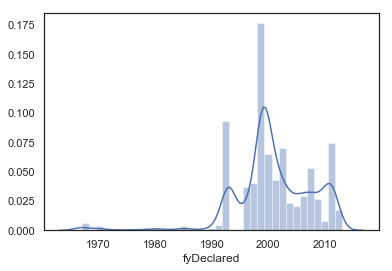

In [13]:
sns.distplot(df.fyDeclared);

In [14]:
# bokeh notebook

from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.sampledata.commits import data
from bokeh.transform import jitter

output_notebook()

MONTHS = [str(i) for i in months]

source = ColumnDataSource(df)

plot = figure(plot_width=950, plot_height=300, y_range=MONTHS, x_axis_type='linear',
           title="US Fire Incidents 1953-2020")

plot.circle(x='fyDeclared', y=jitter('monthDeclared', width=0.6, range=plot.y_range),  source=source, alpha=0.3)
plot.xaxis.axis_label = 'Year'
plot.xaxis.axis_label_text_font_style = "bold"
plot.yaxis.axis_label = 'Month #'
plot.yaxis.axis_label_text_font_style = "bold"

plot.ygrid.grid_line_color = None

show(plot);

Loading BokehJS ...

In [15]:
df_summary = df.groupby(['fyDeclared']).size().reset_index(name="annual_#_of_fires")

In [16]:
# bokeh notebook

x, y = df_summary['fyDeclared'], df_summary['annual_#_of_fires']

# Basic plot setup
plot = figure(plot_width=900, plot_height=500,
              x_axis_type="linear", tools="pan,xzoom_in,reset",
              toolbar_location="below", 
              title='Annual # of Wildfires:  1953-2018')

plot.background_fill_color = "black"
plot.background_fill_alpha = 0.005

plot.line(x, y, line_dash="4 4", line_width=1, color='gray')
plot.xaxis.axis_label = 'Year'
plot.xaxis.axis_label_text_font_style = "bold"
plot.yaxis.axis_label = '# of Fires'
plot.yaxis.axis_label_text_font_style = "bold"

cr = plot.circle(x, y, size=25,
                fill_color="grey", hover_fill_color="firebrick",
                fill_alpha=0.15, hover_alpha=0.3,
                line_color=None, hover_line_color="white")

source = ColumnDataSource(df_summary)
TOOLTIPS = [("DATE", '$fyDeclared')]
plot.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[cr], mode='vline'))

show(plot)


In [17]:
df_summary_months = df.groupby(['fyDeclared', 'monthDeclared']).size().reset_index(name="monthly_fires_by_year")
df_summary_months['fires_this_year'] = df.groupby(['fyDeclared'])['fyDeclared'].agg('sum')
df_summary_months

,fyDeclared,monthDeclared,monthly_fires_by_year,fires_this_year
0,1967,8,10,NaN
1,1970,9,6,NaN
2,1973,10,1,NaN
3,1975,12,1,NaN
4,1977,1,1,NaN
5,1978,10,1,NaN
6,1980,11,4,NaN
7,1981,12,1,NaN
8,1982,4,1,NaN
9,1985,7,6,NaN
